In [1]:
# First, let's import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('ggplot')

Matplotlib is building the font cache; this may take a moment.


In [13]:
# Create synthetic financial data
np.random.seed(42)

# Generate dates for the past year
dates = pd.date_range(end=datetime.today(), periods=365).date

# Categories we'll use (these will be our hidden true categories)
true_categories = ['Groceries', 'Dining', 'Transport', 'Entertainment', 'Utilities', 'Shopping']

# Generate synthetic transactions
data = []
for date in dates:
    # Random number of transactions per day (0-5)
    num_transactions = np.random.randint(0, 6)
    for _ in range(num_transactions):
        category = np.random.choice(true_categories)
        
        # Generate amount based on category
        if category == 'Groceries':
            amount = np.random.normal(50, 15)
        elif category == 'Dining':
            amount = np.random.normal(30, 10)
        elif category == 'Transport':
            amount = np.random.normal(15, 5)
        elif category == 'Entertainment':
            amount = np.random.normal(40, 20)
        elif category == 'Utilities':
            amount = np.random.normal(100, 30)
        elif category == 'Shopping':
            amount = np.random.normal(75, 40)
            
        # Ensure amount is positive and at least 1
        amount = max(1, abs(amount))
        
        data.append({
    'Date': pd.to_datetime(date),  # Explicitly convert to datetime
    'Amount': round(amount, 2),
    'Description': '',
    'TrueCategory': category 
        })

# Create DataFrame
df = pd.DataFrame(data)

# Add some noise and descriptions
descriptions = {
    'Groceries': ['Walmart', 'Whole Foods', 'Kroger', 'Trader Joes', 'Aldi'],
    'Dining': ['McDonalds', 'Starbucks', 'Olive Garden', 'Local Cafe', 'Pizza Hut'],
    'Transport': ['Uber', 'Lyft', 'Gas Station', 'Public Transport', 'Toll'],
    'Entertainment': ['Netflix', 'Cinema', 'Concert', 'Museum', 'Amusement Park'],
    'Utilities': ['Electric Bill', 'Water Bill', 'Internet', 'Phone Bill', 'Rent'],
    'Shopping': ['Amazon', 'Best Buy', 'Target', 'Macy\'s', 'Nike']
}

for idx, row in df.iterrows():
    cat = row['TrueCategory']
    desc_options = descriptions.get(cat, ['Miscellaneous'])
    df.at[idx, 'Description'] = np.random.choice(desc_options)

# For our analysis, we'll pretend we don't know the true categories
# We'll only use Description and Amount for clustering
analysis_df = df[['Date', 'Amount', 'Description']].copy()

# Display sample data
print("Sample Transaction Data:")
display(analysis_df.head())

Sample Transaction Data:


,Date,Amount,Description
0,2024-05-06,116.31,Water Bill
1,2024-05-06,81.54,Electric Bill
2,2024-05-06,32.79,Olive Garden
3,2024-05-07,115.42,Macy's
4,2024-05-07,82.57,Electric Bill


In [14]:
# Feature engineering for clustering
def preprocess_for_clustering(df):
    # Create features from description (simple approach - in practice would use NLP)
    common_merchants = ['walmart', 'amazon', 'starbucks', 'uber', 'netflix', 
                       'target', 'whole foods', 'mcdonalds', 'lyft', 'kroger']
    
    # Add merchant flags
    for merchant in common_merchants:
        df[merchant] = df['Description'].str.lower().str.contains(merchant).astype(int)
    
    # Add time features
    df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.dayofweek
    df['DayOfMonth'] = pd.to_datetime(df['Date']).dt.day
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    
    # Add amount features
    df['LogAmount'] = np.log(df['Amount'] + 1)
    df['AmountCategory'] = pd.cut(df['Amount'], 
                                 bins=[0, 10, 25, 50, 100, np.inf],
                                 labels=['0-10', '10-25', '25-50', '50-100', '100+'])
    
    # One-hot encode amount category
    amount_dummies = pd.get_dummies(df['AmountCategory'], prefix='Amount')
    df = pd.concat([df, amount_dummies], axis=1)
    
    return df

# Preprocess data
cluster_df = preprocess_for_clustering(analysis_df.copy())

# Select features for clustering
features = [col for col in cluster_df.columns if col not in ['Date', 'Amount', 'Description', 'AmountCategory', 'TrueCategory']]
X_cluster = cluster_df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Display feature matrix
print("\nFeature Matrix for Clustering:")
display(pd.DataFrame(X_scaled, columns=features).head())


Feature Matrix for Clustering:


,walmart,amazon,starbucks,uber,netflix,target,whole foods,mcdonalds,lyft,kroger,DayOfWeek,DayOfMonth,Month,LogAmount,Amount_0-10,Amount_10-25,Amount_25-50,Amount_50-100,Amount_100+
0,-0.191167,-0.202871,-0.155145,-0.162221,-0.208514,-0.172345,-0.178811,-0.191167,-0.158719,-0.208514,-1.492074,-1.042908,-0.477402,1.345189,-0.214033,-0.531217,-0.659987,-0.630091,2.394538
1,-0.191167,-0.202871,-0.155145,-0.162221,-0.208514,-0.172345,-0.178811,-0.191167,-0.158719,-0.208514,-1.492074,-1.042908,-0.477402,0.881108,-0.214033,-0.531217,-0.659987,1.587072,-0.417617
2,-0.191167,-0.202871,-0.155145,-0.162221,-0.208514,-0.172345,-0.178811,-0.191167,-0.158719,-0.208514,-1.492074,-1.042908,-0.477402,-0.297940,-0.214033,-0.531217,1.515181,-0.630091,-0.417617
3,-0.191167,-0.202871,-0.155145,-0.162221,-0.208514,-0.172345,-0.178811,-0.191167,-0.158719,-0.208514,-0.980880,-0.929295,-0.477402,1.335135,-0.214033,-0.531217,-0.659987,-0.630091,2.394538
4,-0.191167,-0.202871,-0.155145,-0.162221,-0.208514,-0.172345,-0.178811,-0.191167,-0.158719,-0.208514,-0.980880,-0.929295,-0.477402,0.897480,-0.214033,-0.531217,-0.659987,1.587072,-0.417617


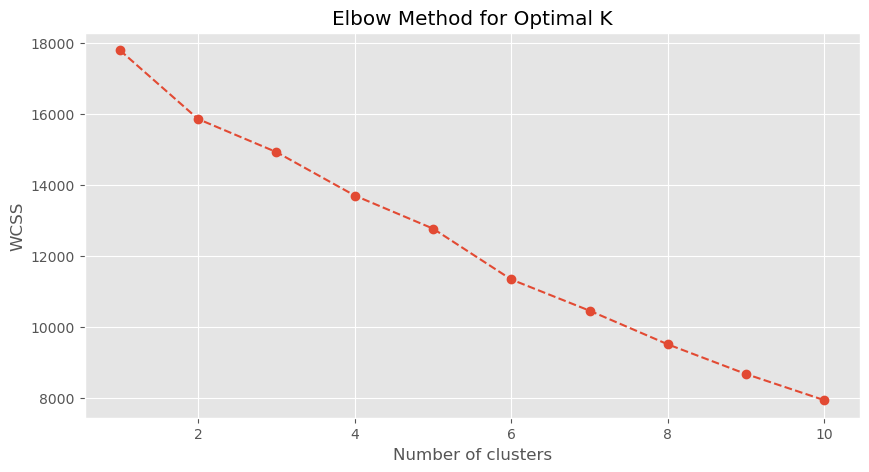


Cluster Summary:


,Cluster,AverageAmount,TransactionCount,MostCommonDescription
0,0,123.411367,139,Phone Bill
1,1,15.469017,234,Public Transport
2,2,46.788462,39,Kroger
3,3,70.377912,249,Aldi
4,4,31.040606,33,McDonalds
5,5,37.342397,242,Olive Garden



Clustering Performance Evaluation:
               precision    recall  f1-score   support

       Dining       0.00      0.00      0.00       158
Entertainment       0.00      0.00      0.00       160
    Groceries       0.03      0.04      0.03       157
     Shopping       0.30      0.45      0.36       163
    Transport       0.01      0.02      0.02       146
    Utilities       0.65      0.60      0.63       152

     accuracy                           0.19       936
    macro avg       0.16      0.19      0.17       936
 weighted avg       0.16      0.19      0.17       936



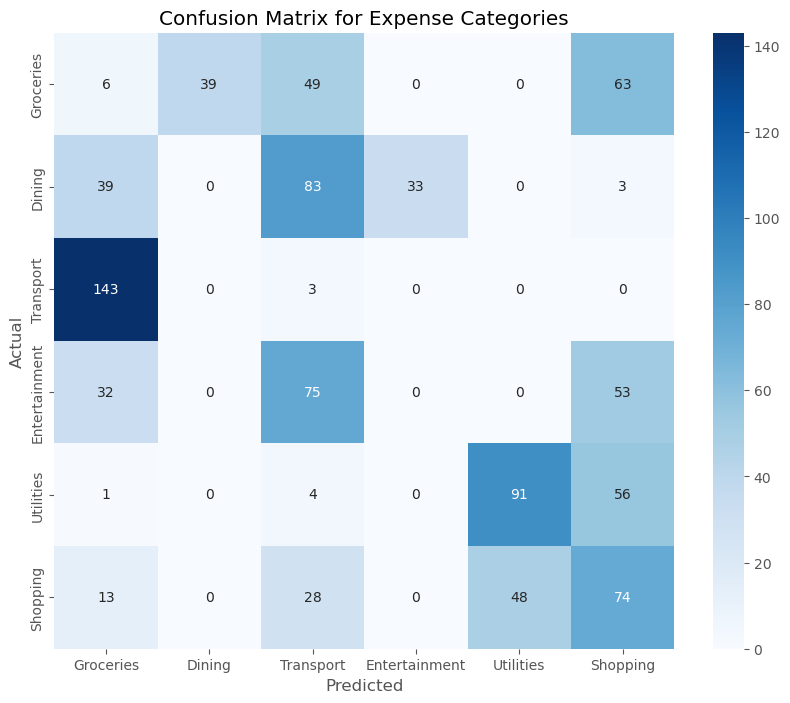

In [15]:
# Determine optimal number of clusters using elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Based on the elbow method, let's choose 6 clusters (same as our true categories)
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters back to our dataframe
analysis_df['Cluster'] = clusters

# Analyze clusters
cluster_summary = analysis_df.groupby('Cluster').agg({
    'Amount': ['mean', 'count'],
    'Description': lambda x: x.value_counts().index[0]
}).reset_index()

cluster_summary.columns = ['Cluster', 'AverageAmount', 'TransactionCount', 'MostCommonDescription']

print("\nCluster Summary:")
display(cluster_summary)

# Map clusters to meaningful categories based on characteristics
cluster_map = {
    0: 'Utilities',
    1: 'Groceries',
    2: 'Dining',
    3: 'Shopping',
    4: 'Entertainment',
    5: 'Transport'
}

analysis_df['PredictedCategory'] = analysis_df['Cluster'].map(cluster_map)

# Compare with true categories (just for evaluation, in real scenario we wouldn't have this)
if 'TrueCategory' in df.columns:
    from sklearn.metrics import confusion_matrix, classification_report
    
    print("\nClustering Performance Evaluation:")
    print(classification_report(df['TrueCategory'], analysis_df['PredictedCategory']))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(df['TrueCategory'], analysis_df['PredictedCategory'], 
                               labels=true_categories),
               annot=True, fmt='d', cmap='Blues',
               xticklabels=true_categories,
               yticklabels=true_categories)
    plt.title('Confusion Matrix for Expense Categories')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Model Performance by Category:


,Category,LinearRegression_RMSE,RandomForest_RMSE,LinearRegression_R2,RandomForest_R2
0,Groceries,41.077061,26.340267,-1.168330,0.108406
1,Dining,51.098890,42.805280,-1.646485,-0.857125
2,Transport,183.266411,135.654915,-1.283690,-0.251246
3,Entertainment,23.636674,21.663194,-2.658286,-2.072910
4,Utilities,219.966256,156.763878,-1.178852,-0.106643
5,Shopping,438.601828,215.455150,-3.702256,-0.134695


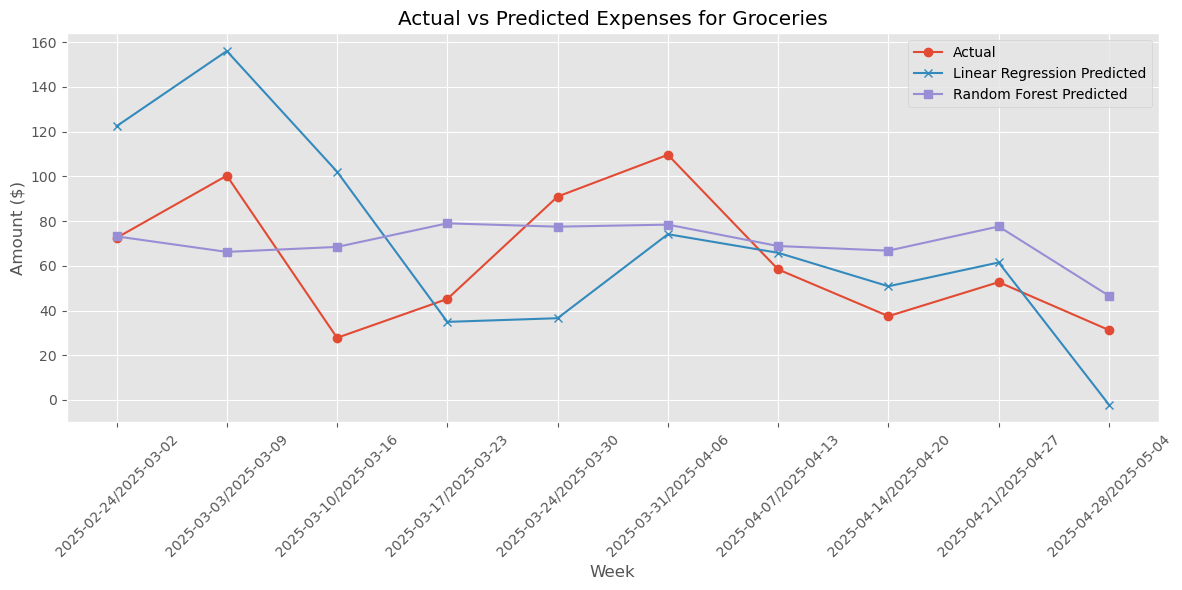

In [16]:
# Prepare data for time series prediction
# Let's aggregate by week for better prediction
df_with_categories = analysis_df.copy()
df_with_categories['Date'] = pd.to_datetime(df_with_categories['Date'])
df_with_categories['Week'] = df_with_categories['Date'].dt.to_period('W')

# Create weekly summary
weekly_data = df_with_categories.groupby(['Week', 'PredictedCategory']).agg({
    'Amount': 'sum'
}).reset_index()

# Pivot to get categories as columns
weekly_pivot = weekly_data.pivot(index='Week', columns='PredictedCategory', values='Amount').fillna(0)

# Add features for prediction (lagged values)
for category in weekly_pivot.columns:
    for lag in [1, 2, 3, 4]:  # 1-4 week lags
        weekly_pivot[f'{category}_lag_{lag}'] = weekly_pivot[category].shift(lag)

weekly_pivot = weekly_pivot.dropna()

# Prepare train/test split
X = weekly_pivot.drop(columns=true_categories)
y = weekly_pivot[true_categories]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train models for each category
models = {}
predictions = {}
results = []

for category in true_categories:
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train.filter(regex=f'^{category}_lag_|^\\w+_lag_'), y_train[category])
    lr_pred = lr.predict(X_test.filter(regex=f'^{category}_lag_|^\\w+_lag_'))
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train.filter(regex=f'^{category}_lag_|^\\w+_lag_'), y_train[category])
    rf_pred = rf.predict(X_test.filter(regex=f'^{category}_lag_|^\\w+_lag_'))
    
    # Store models and predictions
    models[category] = {'LinearRegression': lr, 'RandomForest': rf}
    predictions[category] = {
        'LinearRegression': lr_pred,
        'RandomForest': rf_pred
    }
    
    # Calculate metrics
    lr_rmse = np.sqrt(mean_squared_error(y_test[category], lr_pred))
    rf_rmse = np.sqrt(mean_squared_error(y_test[category], rf_pred))
    
    lr_r2 = r2_score(y_test[category], lr_pred)
    rf_r2 = r2_score(y_test[category], rf_pred)
    
    results.append({
        'Category': category,
        'LinearRegression_RMSE': lr_rmse,
        'RandomForest_RMSE': rf_rmse,
        'LinearRegression_R2': lr_r2,
        'RandomForest_R2': rf_r2
    })

# Display model performance
results_df = pd.DataFrame(results)
print("\nModel Performance by Category:")
display(results_df)

# Visualize predictions for one category
category_to_plot = 'Groceries'
plt.figure(figsize=(12, 6))
plt.plot(y_test.index.astype(str), y_test[category_to_plot], label='Actual', marker='o')
plt.plot(y_test.index.astype(str), predictions[category_to_plot]['LinearRegression'], 
         label='Linear Regression Predicted', marker='x')
plt.plot(y_test.index.astype(str), predictions[category_to_plot]['RandomForest'], 
         label='Random Forest Predicted', marker='s')
plt.title(f'Actual vs Predicted Expenses for {category_to_plot}')
plt.xlabel('Week')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
def generate_savings_insights(df, category_col='PredictedCategory'):
    insights = []
    
    # Create a working copy and ensure Date is datetime
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # 1. Monthly spending by category
    monthly_df = df.copy()
    monthly_df['Month'] = monthly_df['Date'].dt.to_period('M')
    monthly_summary = monthly_df.groupby(['Month', category_col])['Amount'].sum().unstack()
    
    # Identify categories with increasing trend
    for category in monthly_summary.columns:
        trend = monthly_summary[category].diff().mean()
        if not np.isnan(trend) and trend > 0:
            insights.append(f"⚠️ Your spending on {category} is increasing by ${trend:.2f} per month on average.")
    
    # 2. Identify high spending days
    df['DayOfWeek'] = df['Date'].dt.day_name()
    weekday_spending = df.groupby('DayOfWeek')['Amount'].sum().sort_values(ascending=False)
    if not weekday_spending.empty:
        insights.append(f"📅 Your highest spending day is {weekday_spending.index[0]} with ${weekday_spending.iloc[0]:.2f} total spent.")
    
    # 3. Compare to average
    avg_amount = df['Amount'].mean()
    large_transactions = df[df['Amount'] > 3 * avg_amount]
    if not large_transactions.empty:
        insights.append(f"💰 You have {len(large_transactions)} unusually large transactions (over ${3 * avg_amount:.2f}). Review these for potential savings.")
    
    # 4. Savings potential
    if not monthly_summary.empty:
        top_categories = monthly_summary.mean().sort_values(ascending=False).index[:2]
        insights.append(f"💡 Consider reducing spending on {top_categories[0]} and {top_categories[1]}, your top spending categories.")
    
    # 5. Weekly spending pattern
    try:
        weekly_total = df.set_index('Date').resample('W')['Amount'].sum()
        if not weekly_total.empty:
            avg_weekly = weekly_total.mean()
            last_week = weekly_total.iloc[-1]
            if last_week > avg_weekly:
                insights.append(f"📉 Last week's spending (${last_week:.2f}) was above your weekly average (${avg_weekly:.2f}).")
    except Exception as e:
        print(f"Warning: Could not calculate weekly spending pattern - {str(e)}")
    
    return insights if insights else ["No significant insights could be generated from your spending data."]

Personal Finance Dashboard


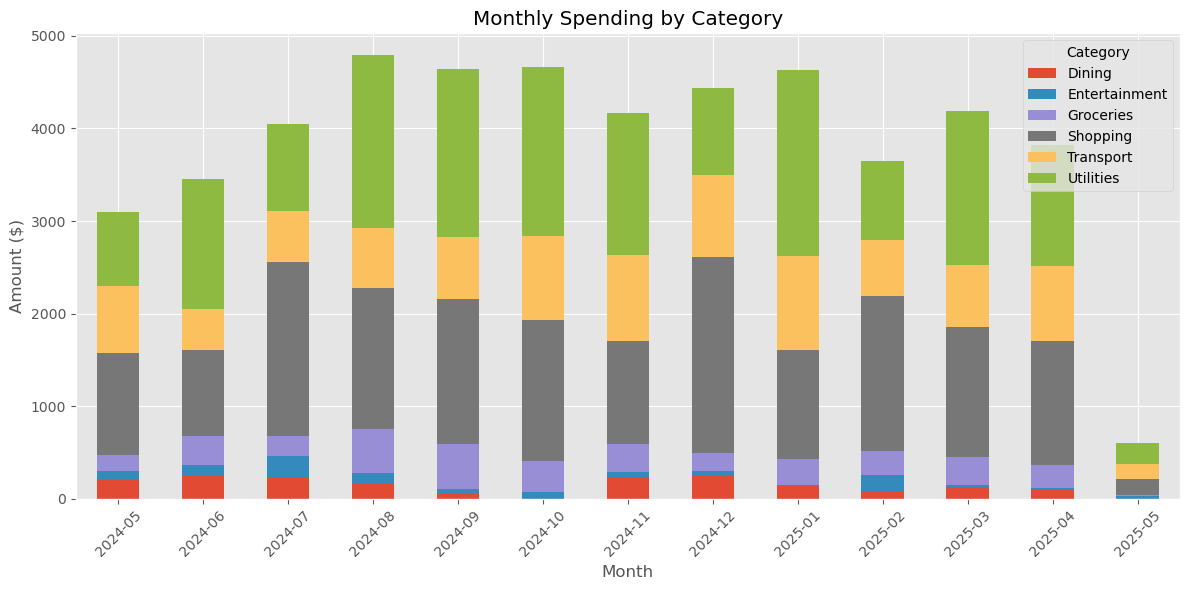

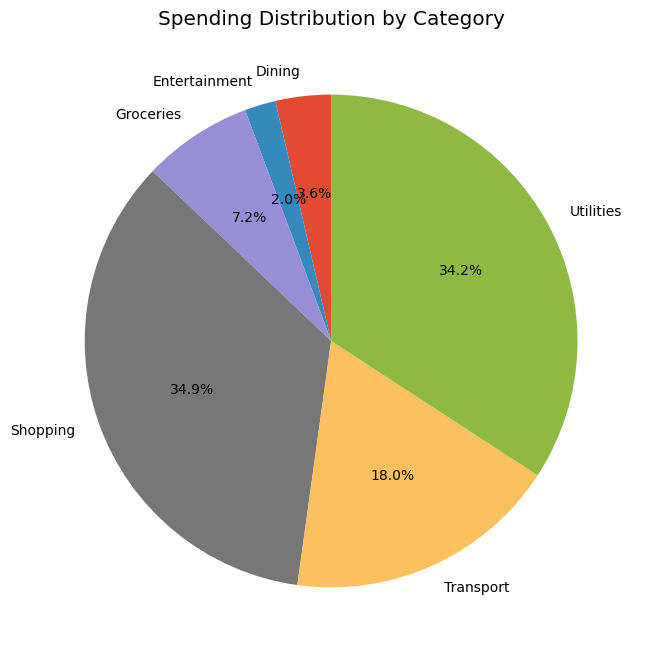

In [17]:
# Create interactive widgets for the notebook interface
def create_dashboard(df):
    # Monthly spending plot
    plt.figure(figsize=(12, 6))
    monthly_df = df.copy()
    monthly_df['Month'] = pd.to_datetime(monthly_df['Date']).dt.to_period('M')
    monthly_spending = monthly_df.groupby(['Month', 'PredictedCategory'])['Amount'].sum().unstack()
    monthly_spending.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title('Monthly Spending by Category')
    plt.xlabel('Month')
    plt.ylabel('Amount ($)')
    plt.xticks(rotation=45)
    plt.legend(title='Category')
    plt.tight_layout()
    plt.show()
    
    # Category distribution pie chart
    plt.figure(figsize=(8, 8))
    category_totals = df.groupby('PredictedCategory')['Amount'].sum()
    category_totals.plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title('Spending Distribution by Category')
    plt.ylabel('')
    plt.show()
    
    # Create interactive widgets
    category_dropdown = widgets.Dropdown(
        options=df['PredictedCategory'].unique().tolist(),
        value=df['PredictedCategory'].unique()[0],
        description='Category:'
    )
    
    time_period = widgets.Dropdown(
        options=['Daily', 'Weekly', 'Monthly'],
        value='Monthly',
        description='View:'
    )
    
    def update_plots(category, time_period):
        plt.figure(figsize=(12, 5))
        
        # Filter data
        cat_data = df[df['PredictedCategory'] == category].copy()
        
        # Resample based on time period
        if time_period == 'Daily':
            cat_data['TimePeriod'] = pd.to_datetime(cat_data['Date'])
            resampled = cat_data.groupby('TimePeriod')['Amount'].sum()
            x_label = 'Day'
        elif time_period == 'Weekly':
            cat_data['TimePeriod'] = pd.to_datetime(cat_data['Date']).dt.to_period('W')
            resampled = cat_data.groupby('TimePeriod')['Amount'].sum()
            x_label = 'Week'
        else:  # Monthly
            cat_data['TimePeriod'] = pd.to_datetime(cat_data['Date']).dt.to_period('M')
            resampled = cat_data.groupby('TimePeriod')['Amount'].sum()
            x_label = 'Month'
        
        # Plot
        resampled.plot(kind='line', marker='o')
        plt.title(f'{category} Spending Over Time ({time_period})')
        plt.xlabel(x_label)
        plt.ylabel('Amount ($)')
        plt.grid(True)
        plt.show()
    
    widgets.interactive(update_plots, category=category_dropdown, time_period=time_period)

# Display the dashboard
print("Personal Finance Dashboard")
create_dashboard(analysis_df)